**1. Importing libraries**

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import optlib.optical as opt
import copy

np.seterr(divide='ignore', invalid='ignore')

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
plt.rcParams['font.size'] = 16
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%matplotlib notebook

**2. Path to the directory containing Henke ionisation data (download from https://henke.lbl.gov/optical_constants/asf.html)**

In [2]:
xraypath = '/Users/olgaridzel/Research/optical-data-fit/sf/'

In [3]:
def plot_fit_results(osc, E0, exp_data):
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    osc.calculateDIIMFP(E0, dE=0.5, decdigs=10)
    axs[0].scatter(exp_data.x_ndiimfp,exp_data.y_ndiimfp,label='Experimental data (REELS)', c='tab:red', alpha=0.2)
    axs[0].plot(osc.DIIMFP_E,osc.DIIMFP,label=r'Fit with $\alpha = $' + f'{round(osc.oscillators.alpha, 2)}')
    axs[0].set_xlabel('Energy loss $\omega$ (eV)')
    axs[0].set_ylabel('nDIIMFP')
    axs[0].legend()
    axs[0].set_xlim(0,100)

    if osc.oscillators.alpha == 0:
        eloss = osc.eloss_extended_to_Henke
        elf = osc.ELF_extended_to_Henke
    else:
        eloss = osc.DIIMFP_E
        elf = osc.ELF[:,0]

    axs[1].scatter(exp_data.x_elf,exp_data.y_elf,label='Experimental data (optical)', c='tab:red', alpha=0.5)
    axs[1].plot(eloss,elf,label=r'Fit with $\alpha = $' + f'{round(osc.oscillators.alpha, 2)}')
    axs[1].set_xlabel('Energy loss $\omega$ (eV)')
    axs[1].set_ylabel('ELF')
    axs[1].legend()
    axs[1].set_xlim(0,100)

    fig.suptitle(f'Fitting results: {osc.name} {osc.oscillators.model} E0 = {E0/1000} keV')
    plt.show()

    plt.savefig(f'{osc.name}_{osc.oscillators.model}_fit.png', dpi=600)

***FITTING PART***

**SiO2**

In [4]:
# A =  [1.7108, 14.0209, 54.6614, 29.8145, 23.110, 57.2744, 24.8628, 163.2707, 51.6461, 18.6274, 281.8416, 30.8553]
# gamma = [8.9366, 16.7689, 7.7492, 3.1000, 2.4844, 5.4080, 63.7768, 85.1598, 61.4630, 25.1917, 99.9989, 49.8264]
# omega = [12.9811, 11.8056, 21.2796, 13.6491, 11.3372, 17.2045, 43.8362, 36.1968, 32.1758, 30.2395, 44.6454, 116.2758]

# good ones
# A = [0.149, 19.37, 55.901, 36.606, 11.748, 144.497, 39.879, 1.857, 53.445, 34.072]
# gamma = [8.318, 1.83, 9.708, 1.756, 0.355, 7.375, 99.332, 99.991, 17.418, 11.506]
# omega = [20.766, 13.743, 22.542, 11.806, 10.405, 16.916, 40.411, 49.59, 32.971, 44.971]
# alpha = 0.8900859116271297

A =     [0.556,  37.505, 75.477, 31.814, 17.688, 96.342, 139.821, 5.328,  95.609, 57.4]
gamma = [8.452,  2.085,  8.568,  1.185,  0.476,  5.014,  99.286,  99.991, 23.645, 21.482]
omega = [20.339, 13.589, 21.512, 11.701, 10.433, 16.725, 66.369,  86.05,  32.086, 50.057]
alpha = 0.9743233997341415

M = (1 * 28.085 + 2 * 15.999) / (1 + 2) # Molar weight
Z_av = (1 * 14 + 2 * 8) / (1 + 2)
rho = 2.19 # g/cm3

oscillators = opt.Oscillators('Drude', A, gamma, omega, alpha = alpha)
composition = opt.Composition(['si','o'], [1,2])
eloss = opt.linspace(0,100,0.1)
q = 0

sio2_drude = opt.Material('SiO2', oscillators, composition, eloss, q, xraypath)
sio2_drude.Eg = 9.1
sio2_drude.width_of_the_valence_band = 10
sio2_drude.atomic_density = rho * opt.N_Avogadro / M *1e-24
sio2_drude.static_refractive_index = 1.4585
sio2_drude.Z = Z_av
sio2_drude.use_henke_for_ne = True # 0.305
sio2_drude.use_KK_constraint = False
sio2_drude.use_kk_relation = False

fsum = sio2_drude.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(sio2_drude.Z))

kksum = sio2_drude.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 10.139533395266104
Z = 10.0
KKSum = 1.0182210368309728


<IPython.core.display.Javascript object>


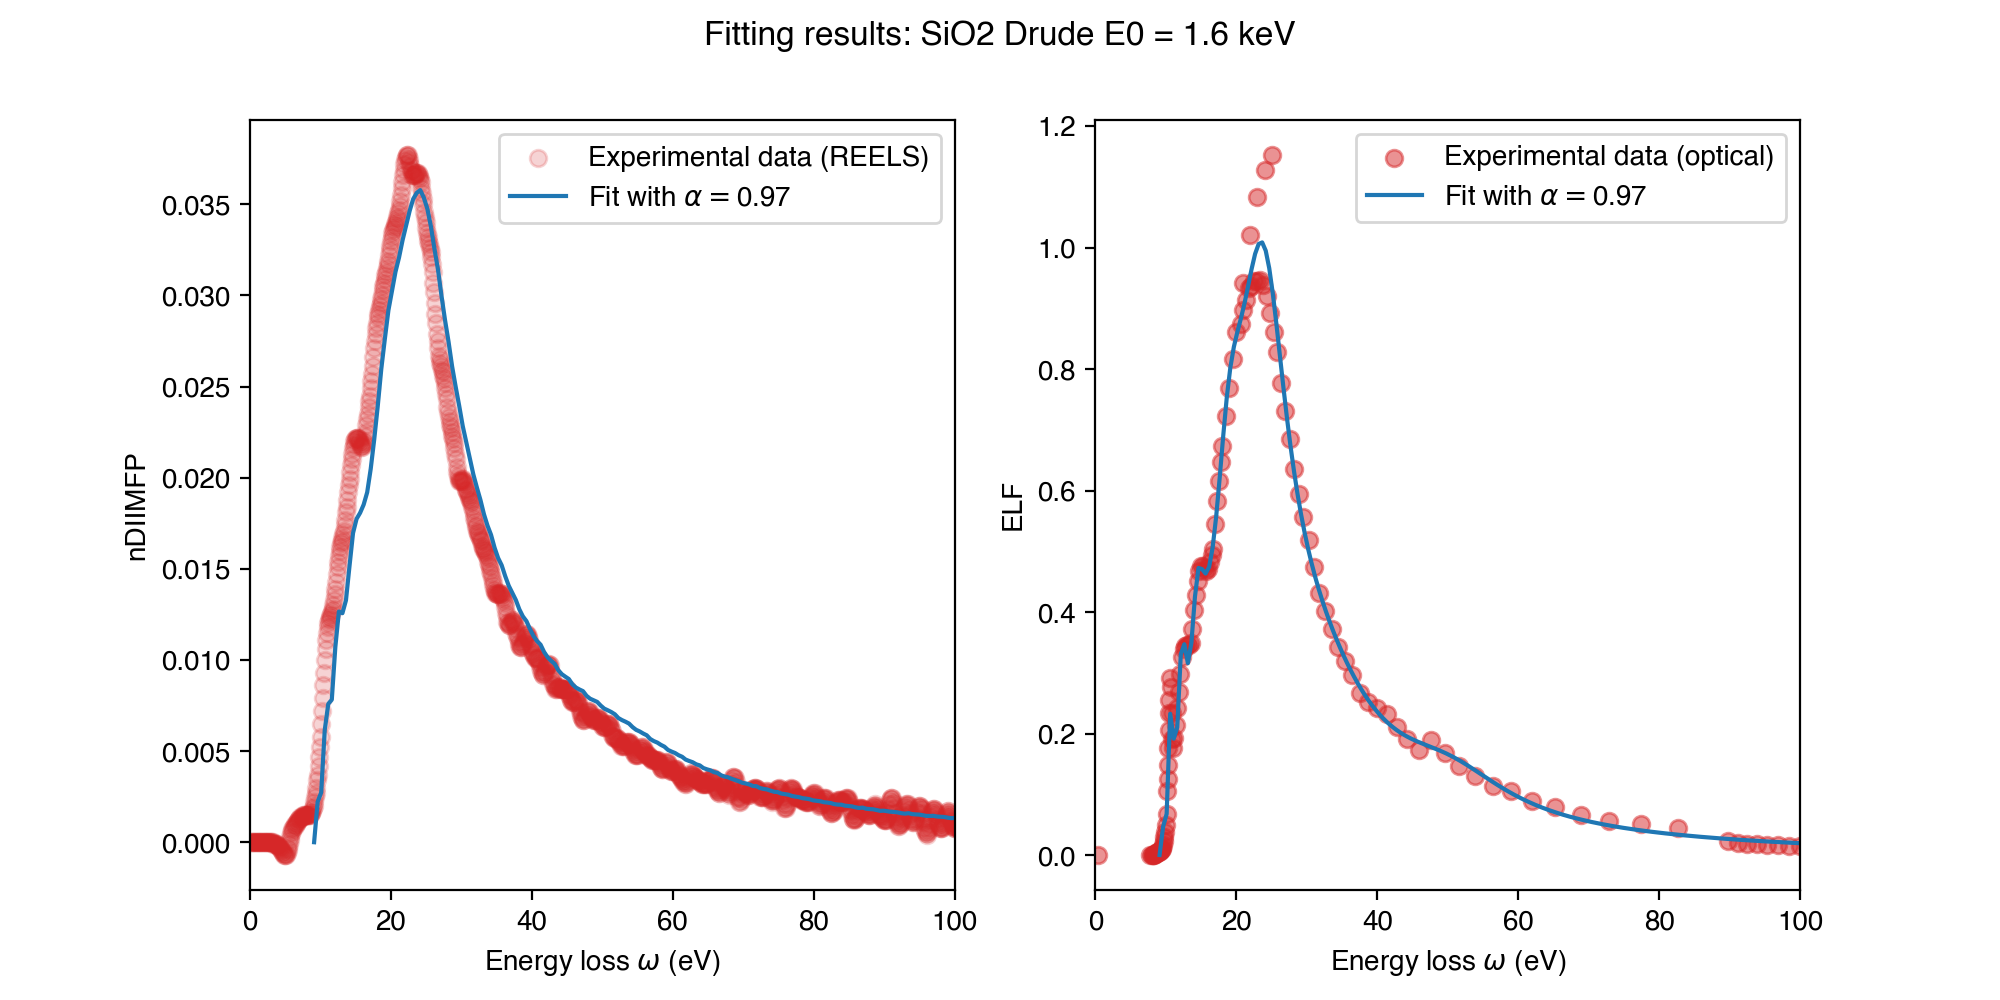

In [5]:
fd = pd.read_csv('../palik_data/sio2pal.txt',sep=' ',header=None)
exp_elf = fd.values

start_ind = 85
exp_eps1 = exp_elf[:,1]**2 - exp_elf[:,2]**2
exp_eps2 = 2 * exp_elf[:,1] * exp_elf[:,2]

x_exp = exp_elf[:,0]
y_exp = exp_eps2 / (exp_eps1**2 + exp_eps2**2)

x_exp_elf = x_exp[::-1][start_ind:]
y_exp_elf = y_exp[::-1][start_ind:]

fd = pd.read_csv('../diimfp/sio2_diimfp.dat',sep=' ',header=None)
exp_diimfp = fd.values
x_exp_ndiimfp = exp_diimfp[:,0]
y_exp_ndiimfp = exp_diimfp[:,1]
E0 = 1600

exp_data = opt.exp_data()
exp_data.x_elf = x_exp_elf
exp_data.y_elf = y_exp_elf
exp_data.x_ndiimfp = x_exp_ndiimfp
exp_data.y_ndiimfp = y_exp_ndiimfp

# opt_ = opt.OptFit(sio2_drude, exp_data, E0, n_q = 8)
# result = opt_.runOptimisation(0.6, 0.4, maxeval = 50000, xtol_rel = 1e-4)
# oscOptimised = opt_.vec2Struct(result)

# fsum = oscOptimised.evaluateFsum()
# print('FSum = {}'.format(fsum))
# print('Z = {}'.format(oscOptimised.Z))

# kksum = oscOptimised.evaluateKKsum()
# print('KKSum = {}'.format(kksum))

# print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
# print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
# print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')
# print(f'alpha = {oscOptimised.oscillators.alpha}')
# print()
# print(f'osc.A = [{" ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}];')
# print(f'osc.G = [{" ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}];')
# print(f'osc.Om = [{" ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}];')

plot_fit_results(sio2_drude, E0, exp_data)
# plot_fit_results(oscOptimised, E0, exp_data)

In [8]:
A = [0.039, 0.156, 0.228, 0.182, 0.0176, 0.0143, 0.0077, 0.101, 0.0442]
gamma = [4.5, 3.5, 10, 8, 2.8, 2, 2.4, 7, 35]
omega = [10, 15.6, 21.5, 27.7, 35.7, 38.2, 42.5, 47.3, 58]
alpha = 0.9

M = (1 * 28.085 + 2 * 15.999) / (1 + 2) # Molar weight
Z_av = (1 * 14 + 2 * 8) / (1 + 2)
rho = 2.19 # g/cm3

oscillators = opt.Oscillators('DrudeLindhard', A, gamma, omega, alpha = alpha)
composition = opt.Composition(['si','o'], [1,2])
eloss = opt.linspace(opt.machine_eps,100,0.1)
q = 0

sio2_dl = opt.Material('SiO2', oscillators, composition, eloss, q, xraypath)
sio2_dl.Eg = 9.1
sio2_dl.width_of_the_valence_band = 10
sio2_dl.atomic_density = rho * opt.N_Avogadro / M *1e-24
sio2_dl.static_refractive_index = 1.4585
sio2_dl.electron_density = sio2_dl.atomic_density * 16
sio2_dl.Z = Z_av
sio2_dl.use_henke_for_ne = False
sio2_dl.use_KK_constraint = False
sio2_dl.use_kk_relation = False

fsum = sio2_dl.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(sio2_dl.Z))

kksum = sio2_dl.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 12.487739849245791
Z = 10.0
KKSum = 1.1807154066000662


In [ ]:
fd = pd.read_csv('../palik_data/sio2pal.txt',sep=' ',header=None)
exp_elf = fd.values

start_ind = 85
exp_eps1 = exp_elf[:,1]**2 - exp_elf[:,2]**2
exp_eps2 = 2 * exp_elf[:,1] * exp_elf[:,2]

x_exp = exp_elf[:,0]
y_exp = exp_eps2 / (exp_eps1**2 + exp_eps2**2)

x_exp_elf = x_exp[::-1][start_ind:]
y_exp_elf = y_exp[::-1][start_ind:]

fd = pd.read_csv('../diimfp/sio2_diimfp.dat',sep=' ',header=None)
exp_diimfp = fd.values
x_exp_ndiimfp = exp_diimfp[:,0]
y_exp_ndiimfp = exp_diimfp[:,1]

exp_data = opt.exp_data()
exp_data.x_elf = x_exp_elf
exp_data.y_elf = y_exp_elf
exp_data.x_ndiimfp = x_exp_ndiimfp
exp_data.y_ndiimfp = y_exp_ndiimfp

opt_ = opt.OptFit(sio2_dl, exp_data, 1600, n_q = 7)
result = opt_.runOptimisation(0.6, 0.4, maxeval = 1000, xtol_rel = 1e-4)
oscOptimised = opt_.vec2Struct(result)

fsum = oscOptimised.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(oscOptimised.Z))

kksum = oscOptimised.evaluateKKsum()
print('KKSum = {}'.format(kksum))

print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')
print(f'alpha = {oscOptimised.oscillators.alpha}')
# print()
# print(f'osc.A = [{" ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}];')
# print(f'osc.G = [{" ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}];')
# print(f'osc.Om = [{" ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}];')

# plot_fit_results(sio2_dl, E0, exp_data)
plot_fit_results(oscOptimised, E0, exp_data)

Starting optimisation...


In [ ]:
osc = oscOptimised
osc.convert_to_MLL()
sio2_mll = osc
sio2_mll.oscillators.model = 'MerminLL'

fsum = sio2_mll.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(sio2_mll.Z))

kksum = sio2_mll.evaluateKKsum()
print('KKSum = {}'.format(kksum))

print(f'A = [{", ".join([str(i) for i in sio2_mll.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in sio2_mll.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in sio2_mll.oscillators.omega.round(3).tolist()])}]')
print(f'U = {sio2_mll.U}')

**CaF2**

In [38]:
A =     [107.53, 75.974, 40.816, 66.906, 95.787, 43.457, 116.051, 70.63, 45.023, 67.381, 26.627, 44.128]
gamma = [30.063, 53.582, 0.641, 1.794, 4.717, 15.281, 1.711, 54.482, 4.044, 2.341, 48.105, 11.593]
omega = [75.524, 63.559, 11.819, 32.336, 24.959, 34.962, 14.175, 57.485, 20.503, 30.082, 60.011, 42.546]
alpha = 0.5680268443450004

M = (1 * 40.078 + 2 * 18.998) / (1 + 2) # Molar weight
Z_av = (1 * 20 + 2 * 9) / (1 + 2)
rho = 3.18 # g/cm3

oscillators = opt.Oscillators('Drude', A, gamma, omega, alpha = alpha)
composition = opt.Composition(['ca','f'], [1,2])
eloss = opt.linspace(opt.machine_eps,100,0.1)
q = 0

caf2_drude = opt.Material('CaF2', oscillators, composition, eloss, q, xraypath)
caf2_drude.Eg = 10
caf2_drude.width_of_the_valence_band = 5.84
caf2_drude.atomic_density = rho * opt.N_Avogadro / M *1e-24
caf2_drude.static_refractive_index = 1.4338
# caf2_drude.electron_density = 0.305
caf2_drude.Z = Z_av
caf2_drude.use_henke_for_ne = True
caf2_drude.use_kk_relation = False

fsum = caf2_drude.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(caf2_drude.Z))

kksum = caf2_drude.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 12.936784568131772
Z = 12.666666666666666
Insulator Eg = 10.0
KKSum = 1.0731374558877977


Starting optimisation...
found minimum after 5000 evaluations
minimum value =  0.005596677619410522
result code =  5
FSum = 13.098148456124068
Z = 12.666666666666666
Insulator Eg = 10.0
KKSum = 1.080192900632888
A = [108.311, 76.456, 44.153, 68.631, 98.198, 42.235, 118.916, 71.116, 44.993, 68.43, 47.184, 50.96]
gamma = [30.142, 53.467, 0.628, 1.814, 4.522, 15.137, 1.737, 54.019, 3.698, 2.335, 48.04, 11.361]
omega = [73.174, 64.932, 11.796, 32.299, 24.958, 35.41, 14.122, 59.735, 20.524, 30.049, 96.949, 42.968]
alpha = 0.5682083451743843


<IPython.core.display.Javascript object>


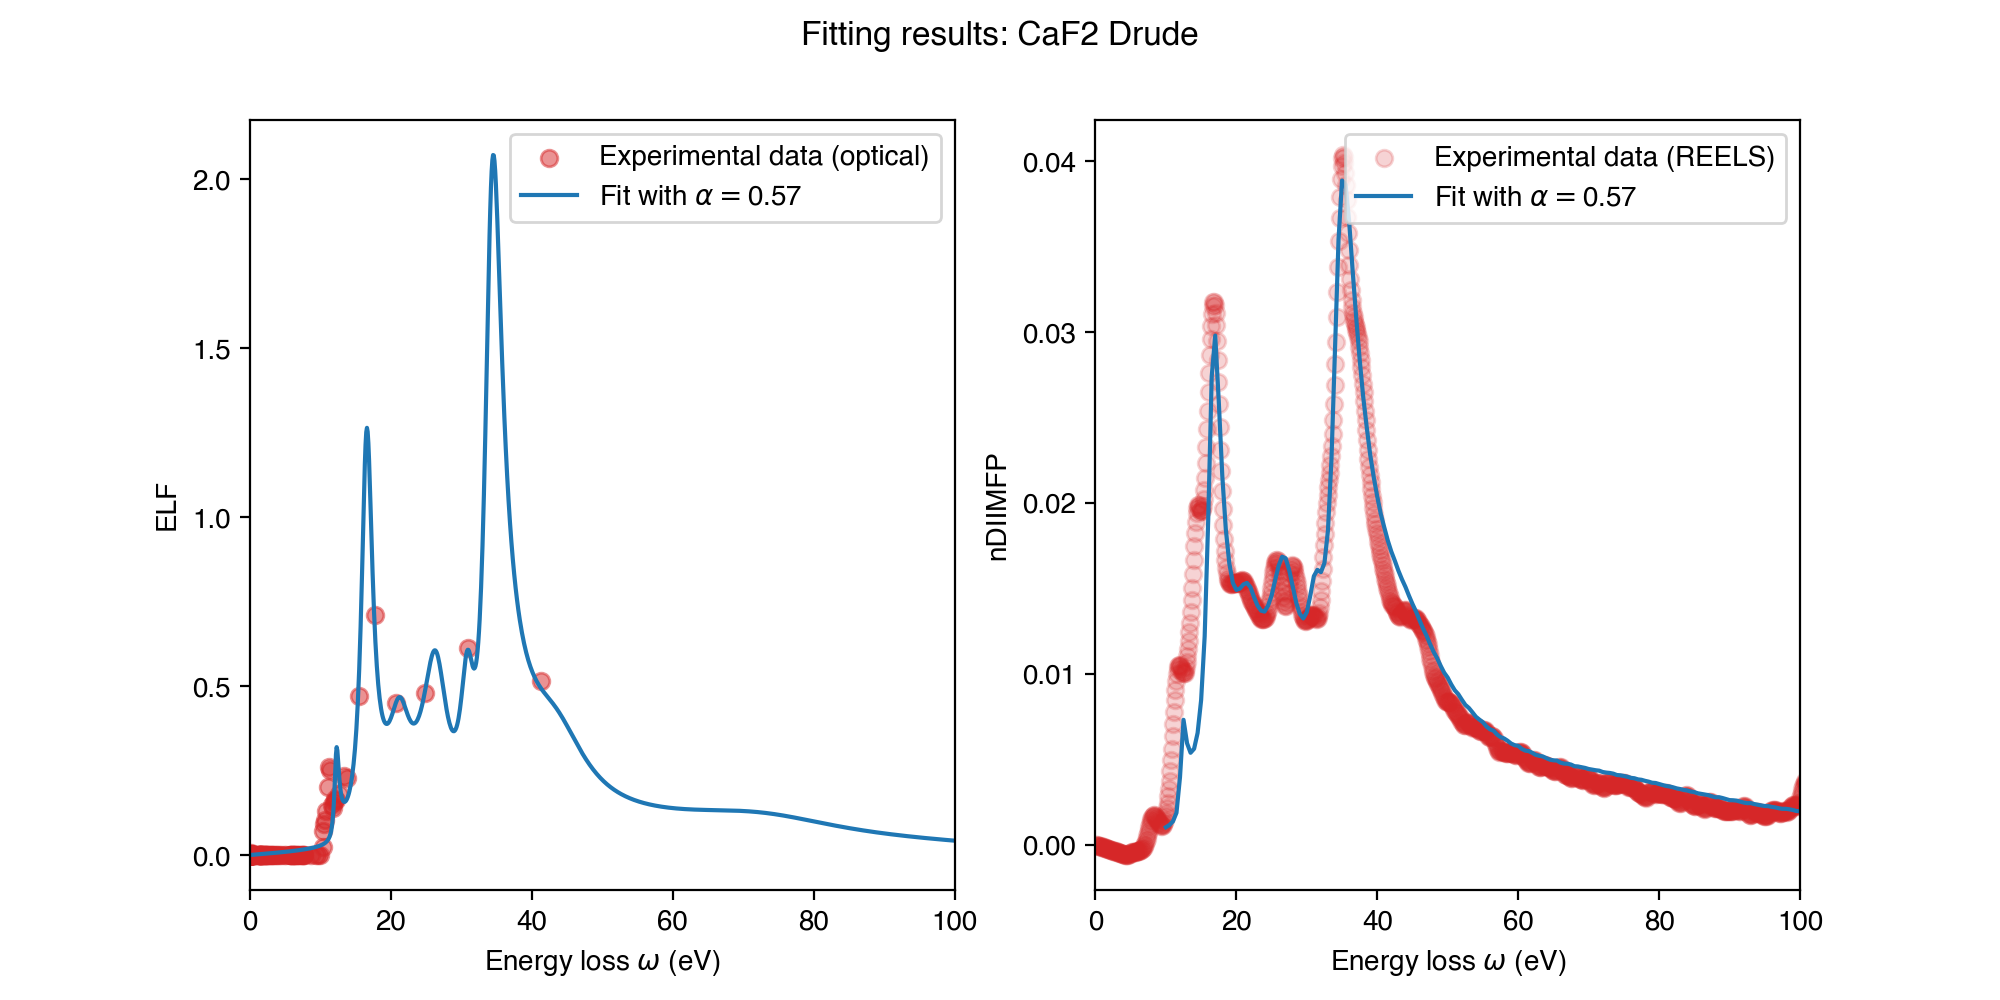

In [39]:
fd = np.loadtxt('/Users/olgaridzel/Research/PHYSDAT/opt/pal/caf2/caf2.pal.csv')
exp_eps1 = fd[:,1]**2 - fd[:,2]**2
exp_eps2 = 2 * fd[:,1] * fd[:,2]

start_ind = 20
ind = np.argsort(fd[:,0])
x_exp = fd[ind,0]
y_exp = exp_eps2[ind] / (exp_eps1[ind]**2 + exp_eps2[ind]**2)

x_exp_elf = x_exp[start_ind:]
y_exp_elf = y_exp[start_ind:]

fd = pd.read_csv('../diimfp/caf2_diimfp.dat',sep=' ',header=None)
exp_diimfp = fd.values
x_exp_ndiimfp = exp_diimfp[:,0]
y_exp_ndiimfp = exp_diimfp[:,1]

exp_data = opt.exp_data()
exp_data.x_elf = x_exp_elf
exp_data.y_elf = y_exp_elf
exp_data.x_ndiimfp = x_exp_ndiimfp
exp_data.y_ndiimfp = y_exp_ndiimfp

opt_ = opt.OptFit(caf2_drude, exp_data, 1600, n_q = 8)
result = opt_.runOptimisation(0.9, 0.1, maxeval = 5000, xtol_rel = 1e-4)
oscOptimised = opt_.vec2Struct(result)

fsum = oscOptimised.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(oscOptimised.Z))

kksum = oscOptimised.evaluateKKsum()
print('KKSum = {}'.format(kksum))

print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')
print(f'alpha = {oscOptimised.oscillators.alpha}')
# print()
# print(f'osc.A = [{" ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}];')
# print(f'osc.G = [{" ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}];')
# print(f'osc.Om = [{" ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}];')

# oscOptimised = caf2_drude
oscOptimised.calculateELF()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].scatter(exp_data.x_elf,exp_data.y_elf,label='Experimental data (optical)', c='tab:red', alpha=0.5)
axs[0].plot(oscOptimised.eloss,oscOptimised.ELF,label=r'Fit with $\alpha = $' + f'{round(oscOptimised.oscillators.alpha, 2)}')
axs[0].set_xlabel('Energy loss $\omega$ (eV)')
axs[0].set_ylabel('ELF')
axs[0].legend()
axs[0].set_xlim(0,100)

oscOptimised.calculateDIIMFP(1600)
axs[1].scatter(exp_data.x_ndiimfp,exp_data.y_ndiimfp,label='Experimental data (REELS)', c='tab:red', alpha=0.2)
axs[1].plot(oscOptimised.DIIMFP_E,oscOptimised.DIIMFP,label=r'Fit with $\alpha = $' + f'{round(oscOptimised.oscillators.alpha, 2)}')
axs[1].set_xlabel('Energy loss $\omega$ (eV)')
axs[1].set_ylabel('nDIIMFP')
axs[1].legend()
axs[1].set_xlim(0,100)

fig.suptitle(f'Fitting results: {oscOptimised.name} {oscOptimised.oscillators.model}')
plt.show()

plt.savefig(f'{oscOptimised.name}_{oscOptimised.oscillators.model}_fit.png', dpi=600)

**HfO2**

In [3]:
# A = [56.846, 8.594, 38.48, 304.488, 57.588, 134.382, 229.363, 134.236, 266.889, 23.168, 90.456, 351.928, 19.129]
# gamma = [4.614, 1.175, 5.903, 35.163, 36.447, 0.952, 17.971, 4.595, 49.734, 2.59, 29.307, 99.999, 81.155]
# omega = [43.707, 9.303, 40.379, 90.546, 32.383, 7.488, 22.138, 10.601, 73.323, 34.424, 32.367, 57.315, 50.304]
# alpha = 0.829914937753153

A = [63.05, 11.993, 47.026, 131.243, 113.829, 244.867, 160.63, 22.857, 125.468, 360.663, 69.534]
gamma = [6.751, 3.208, 4.614, 52.051, 1.169, 17.703, 5.91, 3.768, 96.556, 100.0, 94.022]
omega = [40.985, 9.881, 44.706, 100.153, 7.341, 22.528, 10.418, 34.934, 52.591, 91.441, 107.265]
alpha = 0.93

M = (1 * 178.49 + 2 * 15.999) / (1 + 2) # Molar weight
Z_av = (1 * 72 + 2 * 8) / (1 + 2)
rho = 9.68 # g/cm3

oscillators = opt.Oscillators('Drude', A, gamma, omega, alpha = alpha)
composition = opt.Composition(['hf','o'], [1,2])
eloss = opt.linspace(opt.machine_eps,100,1)
q = 0

hfo2_drude = opt.Material('HfO2', oscillators, composition, eloss, q, xraypath)
hfo2_drude.Eg = 5.6
hfo2_drude.width_of_the_valence_band = 6.5
hfo2_drude.atomic_density = rho * opt.N_Avogadro / M *1e-24
hfo2_drude.static_refractive_index = 1.89 # from Vos paper (hafnia)
hfo2_drude.Z = Z_av
hfo2_drude.use_henke_for_ne = True
hfo2_drude.use_kk_relation = False

fsum = hfo2_drude.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(hfo2_drude.Z))

kksum = hfo2_drude.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 27.930511575049895
Z = 29.333333333333332
Insulator Eg = 5.6
KKSum = 1.0968697961423268


Starting optimisation...
Electron density = 0.6992264162947474
found minimum after 1423 evaluations
minimum value =  0.0015322215166390604
result code =  4
FSum = 26.043999036276354
Z = 29.333333333333332
Insulator Eg = 5.6
KKSum = 0.652655377242187
A = [36.223, 5.675, 53.997, 80.689, 0.0, 241.551, 35.245, 22.501, 48.877, 367.985, 71.413]
gamma = [11.626, 1.513, 6.239, 56.537, 1.158, 21.892, 4.481, 4.891, 97.439, 68.101, 92.224]
omega = [43.096, 13.32, 46.499, 67.603, 8.443, 31.025, 16.348, 59.969, 53.558, 80.74, 68.213]
alpha = 0.893777677863065

osc.A = [36.223 5.675 53.997 80.689 0.0 241.551 35.245 22.501 48.877 367.985 71.413];
osc.G = [11.626 1.513 6.239 56.537 1.158 21.892 4.481 4.891 97.439 68.101 92.224];
osc.Om = [43.096 13.32 46.499 67.603 8.443 31.025 16.348 59.969 53.558 80.74 68.213];


<IPython.core.display.Javascript object>


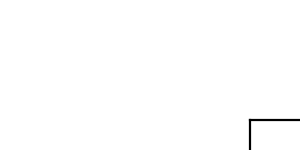

In [6]:
fd_behar = np.loadtxt('/Users/olgaridzel/Research/olga-optical-data/MATLAB/inorganic/hfo2/elf_behar.csv', delimiter=',')
fd_jin = np.loadtxt('/Users/olgaridzel/Research/olga-optical-data/MATLAB/inorganic/hfo2/elf_jin.csv', delimiter=',')

x_exp_elf = np.concatenate((fd_behar[:,0], fd_jin[:,0]))
y_exp_elf = np.concatenate((fd_behar[:,1], fd_jin[:,1]))

fd = np.loadtxt('../diimfp/hfo2_diimfp.dat')
x_exp_ndiimfp = fd[:,0]
y_exp_ndiimfp = fd[:,1]
E0 = 1600

# fd = np.loadtxt('hfo2/ndiimfp_vos_5.csv', delimiter=',')
# x_exp_ndiimfp = fd[:,0]
# y_exp_ndiimfp = fd[:,1]
# E0 = 5000

# fd = np.loadtxt('hfo2/ndiimfp_vos_40.csv', delimiter=',')
# x_exp_ndiimfp = fd[:,0]
# y_exp_ndiimfp = fd[:,1]
# E0 = 40000

exp_data = opt.exp_data()
exp_data.x_elf = x_exp_elf
exp_data.y_elf = y_exp_elf
exp_data.x_ndiimfp = x_exp_ndiimfp
exp_data.y_ndiimfp = y_exp_ndiimfp

opt_ = opt.OptFit(hfo2_drude, exp_data, E0, n_q = 6)
result = opt_.runOptimisation(1,0, maxeval = 5000, xtol_rel = 1e-4)
oscOptimised = opt_.vec2Struct(result)

fsum = oscOptimised.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(oscOptimised.Z))

kksum = oscOptimised.evaluateKKsum()
print('KKSum = {}'.format(kksum))

print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')
print(f'alpha = {oscOptimised.oscillators.alpha}')
print()
print(f'osc.A = [{" ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}];')
print(f'osc.G = [{" ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}];')
print(f'osc.Om = [{" ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}];')

# oscOptimised = hfo2_drude

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

oscOptimised.calculateDIIMFP(E0, dE=0.5, decdigs=10)
axs[0].scatter(exp_data.x_ndiimfp,exp_data.y_ndiimfp,label='Experimental data (REELS)', c='tab:red', alpha=0.2)
axs[0].plot(oscOptimised.DIIMFP_E,oscOptimised.DIIMFP,label=r'Fit with $\alpha = $' + f'{round(oscOptimised.oscillators.alpha, 2)}')
axs[0].set_xlabel('Energy loss $\omega$ (eV)')
axs[0].set_ylabel('nDIIMFP')
axs[0].legend()
axs[0].set_xlim(0,100)

if oscOptimised.oscillators.alpha == 0:
    eloss = oscOptimised.eloss_extended_to_Henke
    elf = oscOptimised.ELF_extended_to_Henke
else:
    eloss = oscOptimised.DIIMFP_E
    elf = oscOptimised.ELF[:,0]
    
axs[1].scatter(exp_data.x_elf,exp_data.y_elf,label='Experimental data (optical)', c='tab:red', alpha=0.5)
# axs[1].scatter(fd_behar[:,0],fd_behar[:,1],label='Experimental data Behar (optical)', c='tab:red', alpha=0.5)
axs[1].plot(eloss,elf,label=r'Fit with $\alpha = $' + f'{round(oscOptimised.oscillators.alpha, 2)}')
axs[1].set_xlabel('Energy loss $\omega$ (eV)')
axs[1].set_ylabel('ELF')
axs[1].legend()
axs[1].set_xlim(0,100)

fig.suptitle(f'Fitting results: {oscOptimised.name} {oscOptimised.oscillators.model} E0 = {E0/1000} keV')
plt.show()

plt.savefig(f'{oscOptimised.name}_{oscOptimised.oscillators.model}_fit.png', dpi=600)

Data from Vos

In [6]:
A = [0.039, 0.055, 0.308, 0.113, 0.019, 0.104, 0.08]
gamma = [2.923, 7.831, 15.227, 6.435, 5.291, 11.287, 46.622]
omega = [15.715, 19.936, 27.217, 15.391, 37.559, 47.775, 71.664]
alpha = 0.1

M = (1 * 178.49 + 2 * 15.999) / (1 + 2) # Molar weight
Z_av = (1 * 72 + 2 * 8) / (1 + 2)
rho = 9.68 # g/cm3

oscillators = opt.Oscillators('DrudeLindhard', A, gamma, omega, alpha = alpha)
composition = opt.Composition(['hf','o'], [1,2])
eloss = opt.linspace(opt.machine_eps,80,1)
q = 0

hfo2_dl = opt.Material('HfO2', oscillators, composition, eloss, q, xraypath)
hfo2_dl.Eg = 5.6
hfo2_dl.width_of_the_valence_band = 6.5
hfo2_dl.atomic_density = rho * opt.N_Avogadro / M *1e-24
hfo2_dl.static_refractive_index = 1.89
# hfo2_drude.electron_density = 0.305
hfo2_dl.Z = Z_av
hfo2_dl.use_henke_for_ne = True
hfo2_dl.use_KK_constraint = True
hfo2_dl.use_kk_relation = False
hfo2_dl.U = 5

fsum = hfo2_dl.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(hfo2_dl.Z))

kksum = hfo2_dl.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 27.562245291435055
Z = 29.333333333333332
Insulator Eg = 5.6
KKSum = -10292819243.934294


<IPython.core.display.Javascript object>


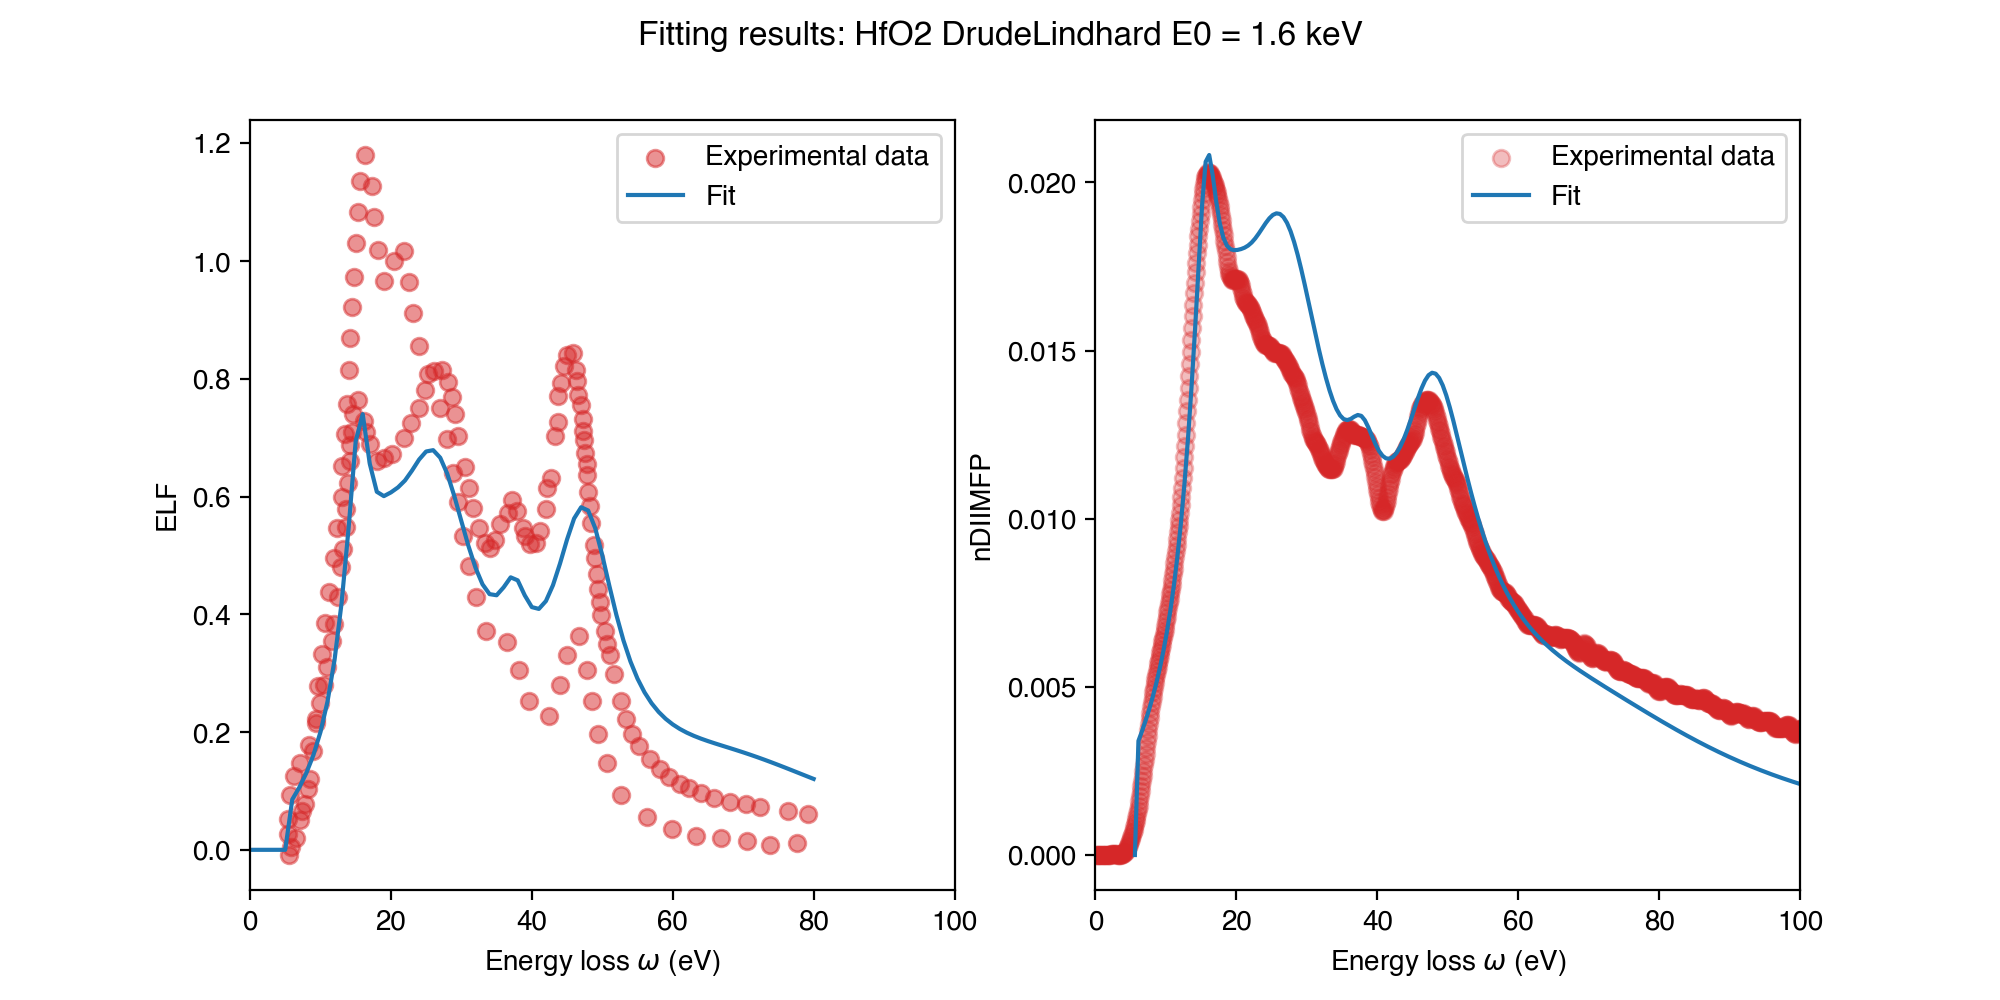

In [7]:
fd_behar = np.loadtxt('/Users/olgaridzel/Research/olga-optical-data/MATLAB/inorganic/hfo2/elf_behar.csv', delimiter=',')
fd_jin = np.loadtxt('/Users/olgaridzel/Research/olga-optical-data/MATLAB/inorganic/hfo2/elf_jin.csv', delimiter=',')

x_exp_elf = np.concatenate((fd_behar[:,0], fd_jin[:,0]))
y_exp_elf = np.concatenate((fd_behar[:,1], fd_jin[:,1]))

fd = np.loadtxt('../diimfp/hfo2_diimfp.dat')
x_exp_ndiimfp = fd[:,0]
y_exp_ndiimfp = fd[:,1]
E0 = 1600

# fd = np.loadtxt('hfo2/ndiimfp_vos_40.csv', delimiter=',')
# x_exp_ndiimfp = fd[:,0]
# y_exp_ndiimfp = fd[:,1]
# E0 = 40000

# fd = np.loadtxt('hfo2/ndiimfp_vos_5.csv', delimiter=',')
# x_exp_ndiimfp = fd[:,0]
# y_exp_ndiimfp = fd[:,1]
# E0 = 5000

exp_data = opt.exp_data()
exp_data.x_elf = x_exp_elf
exp_data.y_elf = y_exp_elf
exp_data.x_ndiimfp = x_exp_ndiimfp
exp_data.y_ndiimfp = y_exp_ndiimfp

# opt_ = opt.OptFit(hfo2_drude_vos_5, exp_data, E0, n_q = 8)
# result = opt_.runOptimisation(1,0, maxeval = 5000, xtol_rel = 1e-4)
# oscOptimised = opt_.vec2Struct(result)

# fsum = oscOptimised.evaluateFsum()
# print('FSum = {}'.format(fsum))
# print('Z = {}'.format(oscOptimised.Z))

# kksum = oscOptimised.evaluateKKsum()
# print('KKSum = {}'.format(kksum))

# print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
# print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
# print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')
# print(f'alpha = {oscOptimised.oscillators.alpha}')
# print()
# print(f'osc.A = [{" ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}];')
# print(f'osc.G = [{" ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}];')
# print(f'osc.Om = [{" ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}];')

oscOptimised = hfo2_dl
oscOptimised.calculateELF()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].scatter(exp_data.x_elf,exp_data.y_elf,label='Experimental data', c='tab:red', alpha = 0.5)
axs[0].plot(oscOptimised.eloss,oscOptimised.ELF,label='Fit')
axs[0].set_xlabel('Energy loss $\omega$ (eV)')
axs[0].set_ylabel('ELF')
axs[0].legend()
axs[0].set_xlim(0,100)

oscOptimised.calculateDIIMFP(1600)
axs[1].scatter(exp_data.x_ndiimfp,exp_data.y_ndiimfp,label='Experimental data', c='tab:red', alpha = 0.3)
axs[1].plot(oscOptimised.DIIMFP_E,oscOptimised.DIIMFP,label='Fit')
axs[1].set_xlabel('Energy loss $\omega$ (eV)')
axs[1].set_ylabel('nDIIMFP')
axs[1].legend()
axs[1].set_xlim(0,100)

fig.suptitle(f'Fitting results: {oscOptimised.name} {oscOptimised.oscillators.model} E0 = {E0/1000} keV')
plt.show()

In [15]:
A = [0.038, 0.051, 0.318, 0.109, 0.018, 0.108, 0.079]
gamma = [2.841, 7.377, 14.661, 6.338, 4.901, 10.504, 48.389]
omega = [15.84, 19.687, 27.307, 15.697, 37.701, 47.883, 71.072]

M = (1 * 178.49 + 2 * 15.999) / (1 + 2) # Molar weight
Z_av = (1 * 72 + 2 * 8) / (1 + 2)
rho = 9.68 # g/cm3

oscillators = opt.Oscillators('DrudeLindhard', A, gamma, omega, alpha = 0.1)
composition = opt.Composition(['hf','o'], [1,2])
eloss = opt.linspace(opt.machine_eps,80,2)
q = 0

hfo2_drude_vos_40 = opt.Material('HfO2', oscillators, composition, eloss, q, xraypath)
hfo2_drude_vos_40.Eg = 5.6
hfo2_drude_vos_40.width_of_the_valence_band = 6.5
hfo2_drude_vos_40.atomic_density = rho * opt.N_Avogadro / M *1e-24
hfo2_drude_vos_40.static_refractive_index = 1.89
hfo2_drude_vos_40.Z = Z_av
hfo2_drude_vos_40.use_henke_for_ne = True
hfo2_drude_vos_40.use_KK_constraint = True
hfo2_drude_vos_40.use_kk_relation = False

fsum = hfo2_drude_vos_40.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(hfo2_drude_vos_40.Z))

kksum = hfo2_drude_vos_40.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 27.63315716089351
Z = 29.333333333333332
KKSum = 0.9802969303835014


In [ ]:
exp_diimfp = np.loadtxt('hfo2/ndiimfp_vos_40.csv', delimiter=',')
x_exp = exp_diimfp[:,0]
y_exp = exp_diimfp[:,1]

opt_ = opt.OptFit(hfo2_drude_vos_40, x_exp, y_exp, 40000)
result = opt_.runOptimisation('ndiimfp', maxeval = 100, xtol_rel = 1e-20)
oscOptimised = opt_.vec2Struct(result)

fsum = oscOptimised.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(oscOptimised.Z))

kksum = oscOptimised.evaluateKKsum()
print('KKSum = {}'.format(kksum))

print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')

print(f'osc.A = [{" ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}];')
print(f'osc.G = [{" ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}];')
print(f'osc.Om = [{" ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}];')

oscOptimised.calculateDIIMFP(opt_.E0)

plt.figure()
plt.plot(oscOptimised.DIIMFP_E,oscOptimised.DIIMFP,label='Fit')
plt.plot(x_exp,y_exp,label='Experimental data')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('Normalised DIIMFP (eV$^{-1}$)')
plt.title(f'{oscOptimised.name} {oscOptimised.oscillators.model}')
plt.legend()
plt.xlim(0,80)
plt.show()

Start optimisation
Electron density = 0.6992264162947474


In [16]:
A = [0.039, 0.156, 0.228, 0.182, 0.0176, 0.0143, 0.0077, 0.101, 0.0442]
gamma = [4.5, 3.5, 10, 8, 2.8, 2, 2.4, 7, 35]
omega = [10, 15.6, 21.5, 27.7, 35.7, 38.2, 42.5, 47.3, 58]

M = (1 * 178.49 + 2 * 15.999) / (1 + 2) # Molar weight
Z_av = (1 * 72 + 2 * 8) / (1 + 2)
rho = 9.68 # g/cm3

oscillators = opt.Oscillators('DrudeLindhard', A, gamma, omega, alpha = 0.1)
composition = opt.Composition(['hf','o'], [1,2])
eloss = opt.linspace(opt.machine_eps,80,0.1)
q = 0

hfo2_drude_vos = opt.Material('HfO2', oscillators, composition, eloss, q, xraypath)
hfo2_drude_vos.Eg = 5.6
hfo2_drude_vos.width_of_the_valence_band = 6.5
hfo2_drude_vos.atomic_density = rho * opt.N_Avogadro / M *1e-24
hfo2_drude_vos.static_refractive_index = 1.89
hfo2_drude_vos.Z = Z_av
hfo2_drude_vos.use_henke_for_ne = True
hfo2_drude_vos.use_KK_constraint = True
hfo2_drude_vos.use_kk_relation = False

fsum = hfo2_drude_vos.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(hfo2_drude_vos.Z))

kksum = hfo2_drude_vos.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 26.888136254097642
Z = 29.333333333333332
KKSum = 1.0500774477323873


<IPython.core.display.Javascript object>


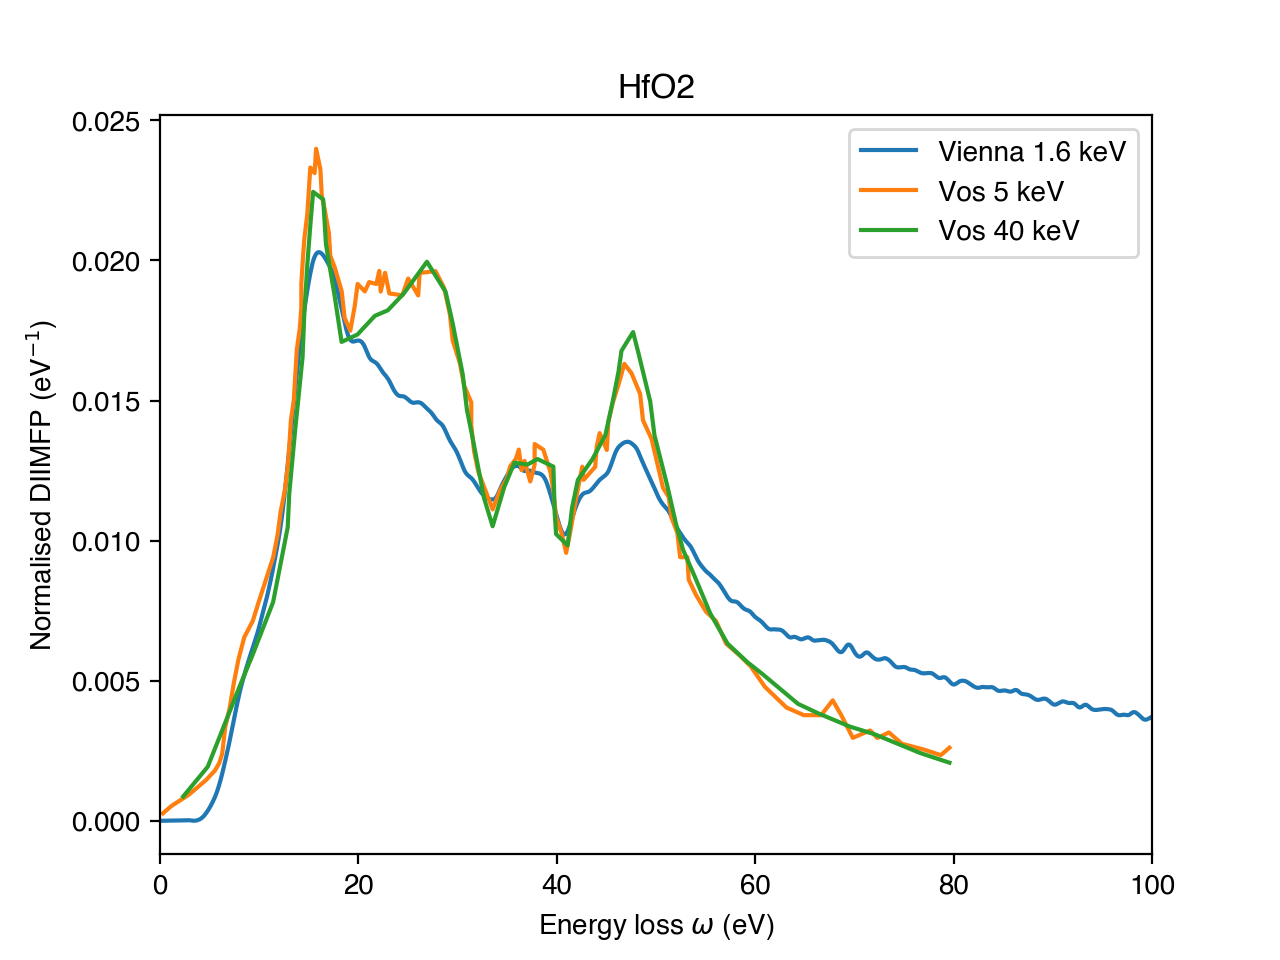

In [84]:
exp_diimfp = np.loadtxt('../diimfp/hfo2_diimfp.dat')
x_exp = exp_diimfp[:,0]
y_exp = exp_diimfp[:,1]

exp_diimfp = np.loadtxt('hfo2/ndiimfp_vos_40.csv', delimiter=',')
x_exp_40 = exp_diimfp[:,0]
y_exp_40 = exp_diimfp[:,1]

exp_diimfp = np.loadtxt('hfo2/ndiimfp_vos_5.csv', delimiter=',')
x_exp_5 = exp_diimfp[:,0]
y_exp_5 = exp_diimfp[:,1]

exp_diimfp = np.loadtxt('hfo2/ndiimfp_jin_500_ev.csv', delimiter=',')
x_exp_jin = exp_diimfp[:,0]
y_exp_jin = exp_diimfp[:,1]

plt.figure()
# plt.plot(x_exp_jin,y_exp_jin,label='Jin 500 eV')
plt.plot(x_exp,y_exp,label='Vienna 1.6 keV')
plt.plot(x_exp_5,y_exp_5,label='Vos 5 keV')
plt.plot(x_exp_40,y_exp_40,label='Vos 40 keV')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('Normalised DIIMFP (eV$^{-1}$)')
plt.title(f'{oscOptimised.name}')
plt.legend()
plt.xlim(0,100)
plt.show()

<IPython.core.display.Javascript object>


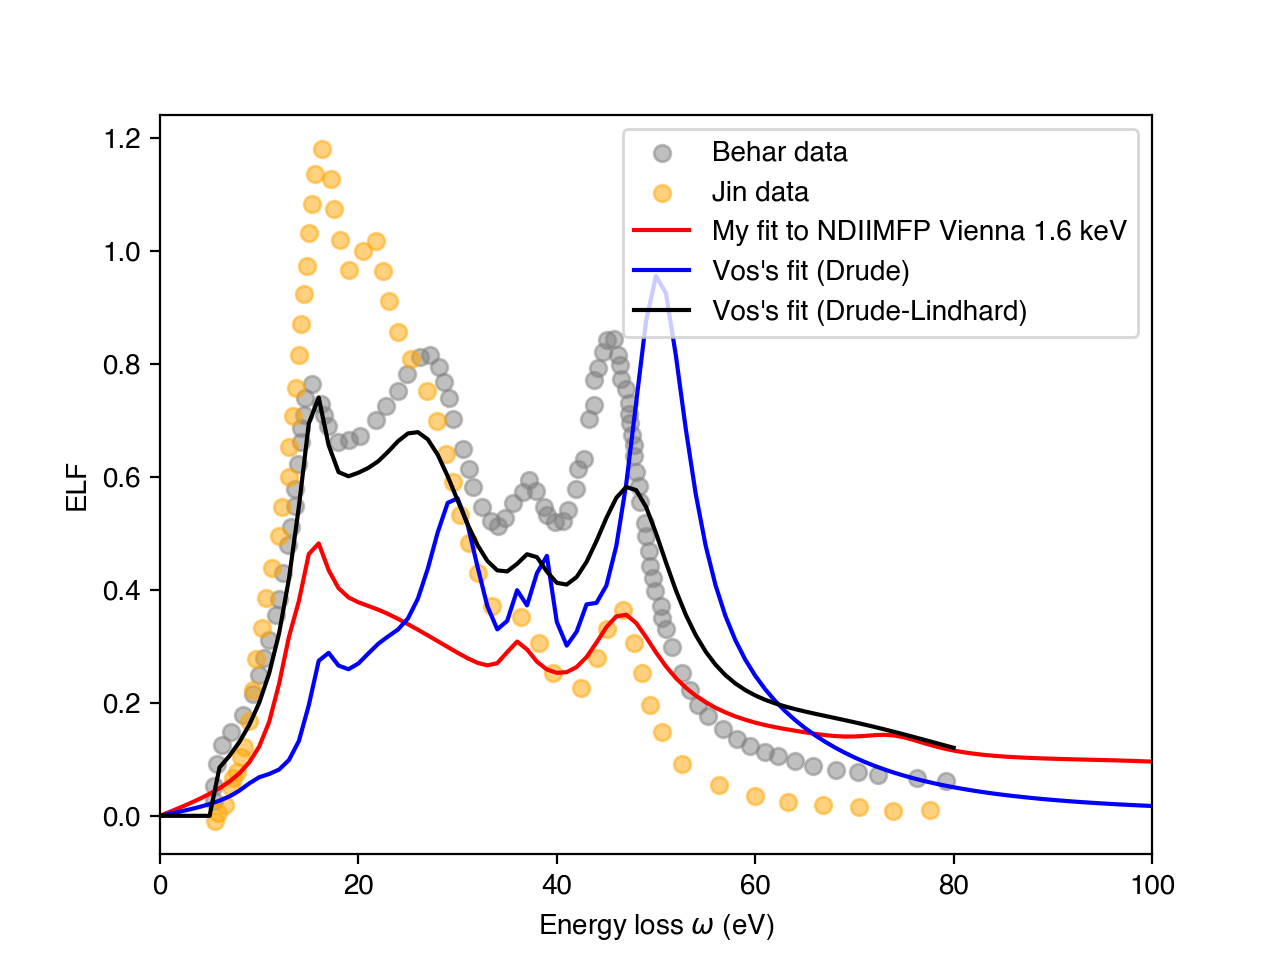

In [26]:
exp_elf_behar = np.loadtxt('hfo2/elf_behar.csv',delimiter=',')
x_exp_elf_behar = exp_elf_behar[:,0]
y_exp_elf_behar = exp_elf_behar[:,1]

exp_elf_jin = np.loadtxt('hfo2/elf_jin.csv',delimiter=',')
x_exp_elf_jin = exp_elf_jin[:,0]
y_exp_elf_jin = exp_elf_jin[:,1]

hfo2_drude.calculateELF()
hfo2_dl.calculateELF()
# hfo2_drude_vos_5.calculateELF()
# hfo2_drude_vos_40.calculateELF()

plt.figure()

plt.scatter(x_exp_elf_behar, y_exp_elf_behar, color='gray', alpha=0.5, label='Behar data')
plt.scatter(x_exp_elf_jin, y_exp_elf_jin, color='orange', alpha=0.5, label='Jin data')

plt.plot(oscOptimised.eloss, oscOptimised.ELF, label='My fit to NDIIMFP Vienna 1.6 keV', color='Red')
# plt.plot(hfo2_drude_vos_5.eloss, hfo2_drude_vos_5.ELF, label=r'My fit to NDIIMFP Vos 5 keV', color='Red')
# plt.plot(hfo2_drude_vos_40.eloss, hfo2_drude_vos_40.ELF, label=r'My fit to NDIIMFP Vos 40 keV', color='green')
plt.plot(hfo2_drude.eloss, hfo2_drude.ELF, label="Vos's fit (Drude)", color='Blue')
plt.plot(hfo2_dl.eloss, hfo2_dl.ELF, label="Vos's fit (Drude-Lindhard)", color='black')

plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('ELF')
# plt.title(hfo2_drude.name + ' ' + hfo2_drude.model + r' $\alpha$ = 0.1')
plt.legend()
plt.xlim(0,100)
plt.show()

plt.savefig("hfo2/hfo2_elfs.png", dpi=600)

In [44]:
A = [22.599, 18.058, 10.548, 36.653, 35.798, 1.351, 31.667, 22.231, 0.002, 0.009, 45.313, 93.291, 90.353, 195.063, 10.668, 60.559, 88.983, 81.493, 108.693, 10.821]
gamma = [6.626, 17.811, 2.914, 7.625, 14.953, 19.729, 25.108, 8.661, 10.83, 17.639, 4.571, 25.609, 15.945, 74.365, 3.803, 35.944, 99.982, 27.938, 51.0, 24.123]
omega = [44.112, 51.857, 15.289, 47.34, 57.502, 63.12, 37.36, 69.618, 86.313, 66.068, 13.066, 29.5, 20.66, 89.118, 36.421, 43.162, 22.868, 90.492, 84.574, 30.638]

M = (1 * 178.49 + 2 * 15.999) / (1 + 2) # Molar weight
Z_av = (1 * 72 + 2 * 8) / (1 + 2)
rho = 9.68 # g/cm3

oscillators = opt.Oscillators('Drude', A, gamma, omega, alpha = 1)
composition = opt.Composition(['hf','o'], [1,2])
eloss = opt.linspace(opt.machine_eps,100,0.1)
q = 0

hfo2_drude_alpha_1 = opt.Material('HfO2', oscillators, composition, eloss, q, xraypath)
hfo2_drude_alpha_1.Eg = 5.6
hfo2_drude_alpha_1.width_of_the_valence_band = 6.5
hfo2_drude_alpha_1.atomic_density = rho * opt.N_Avogadro / M *1e-24
hfo2_drude_alpha_1.static_refractive_index = 1.89
# hfo2_drude_alpha_1.electron_density = 0.305
hfo2_drude_alpha_1.Z = Z_av
hfo2_drude_alpha_1.use_henke_for_ne = True
hfo2_drude_alpha_1.use_KK_constraint = True
hfo2_drude_alpha_1.use_kk_relation = False

fsum = hfo2_drude_alpha_1.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(hfo2_drude_alpha_1.Z))

kksum = hfo2_drude_alpha_1.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 26.28797779993503
Z = 29.333333333333332
KKSum = 0.7388764414789972


Start optimisation
Electron density = 0.6992264162947474
FSum = 26.397231154622325
Z = 29.333333333333332
KKSum = 0.8021650324238212
A = [22.378, 11.137, 19.464, 73.383, 29.401, 1.358, 24.008, 24.371, 0.002, 0.008, 59.889, 121.526, 89.08, 141.525, 16.334, 41.278, 58.909, 77.035, 146.734, 6.345]
gamma = [4.56, 35.992, 3.13, 9.114, 24.332, 33.329, 18.646, 12.301, 22.027, 30.76, 4.353, 24.296, 16.623, 99.36, 4.618, 74.23, 99.99, 20.899, 51.727, 16.819]
omega = [44.509, 44.56, 13.52, 44.2, 63.879, 112.88, 37.741, 68.064, 117.56, 101.785, 11.777, 28.133, 19.292, 82.69, 35.191, 40.061, 23.8, 98.722, 80.353, 30.461]
osc.A = [22.378 11.137 19.464 73.383 29.401 1.358 24.008 24.371 0.002 0.008 59.889 121.526 89.08 141.525 16.334 41.278 58.909 77.035 146.734 6.345];
osc.G = [4.56 35.992 3.13 9.114 24.332 33.329 18.646 12.301 22.027 30.76 4.353 24.296 16.623 99.36 4.618 74.23 99.99 20.899 51.727 16.819];
osc.Om = [44.509 44.56 13.52 44.2 63.879 112.88 37.741 68.064 117.56 101.785 11.777 28.133 19.

<IPython.core.display.Javascript object>


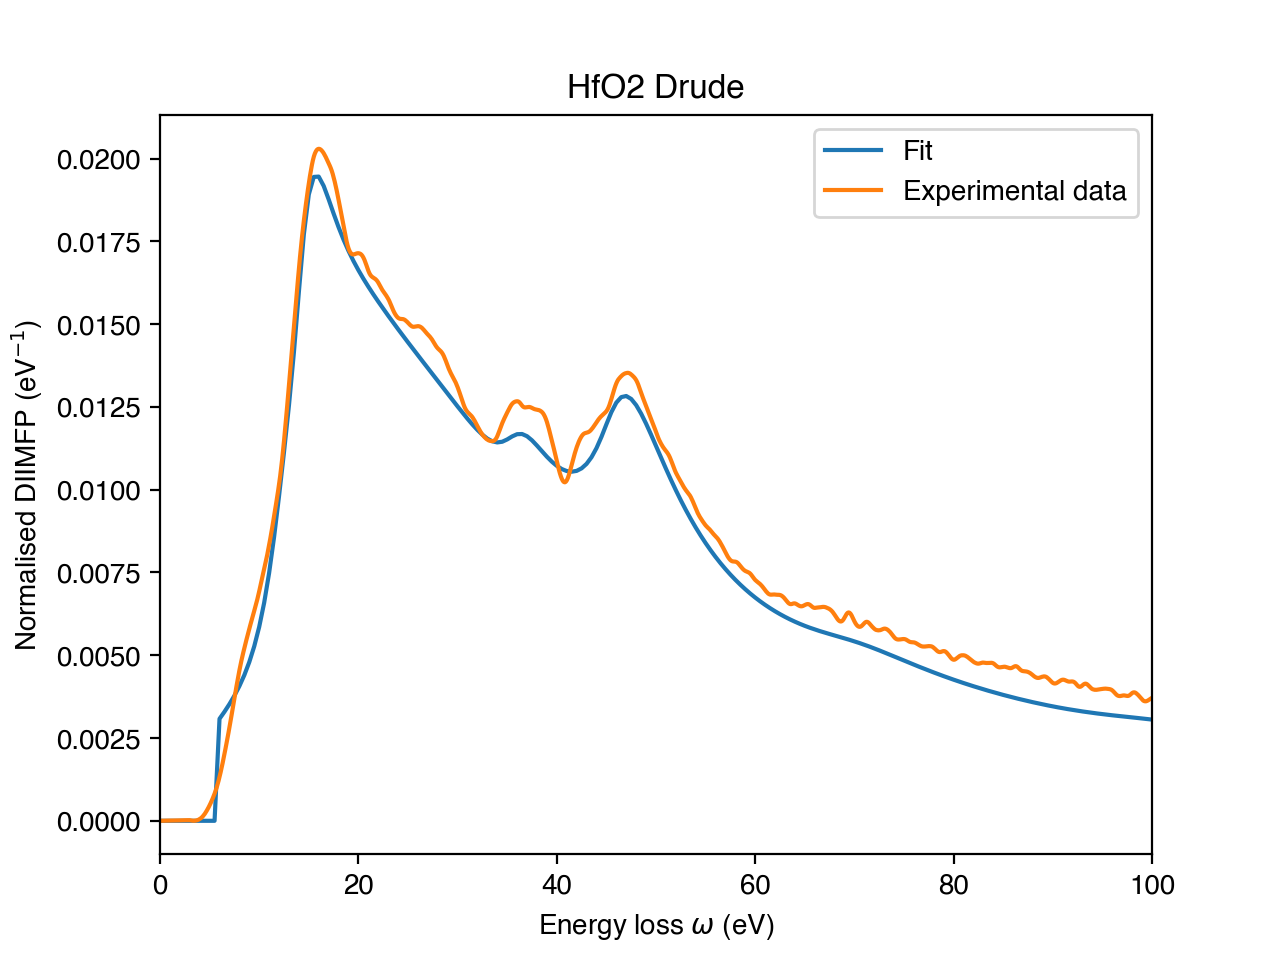

In [46]:
exp_diimfp = np.loadtxt('../diimfp/hfo2_diimfp.dat')
x_exp = exp_diimfp[:,0]
y_exp = exp_diimfp[:,1]

opt_ = opt.OptFit(hfo2_drude_alpha_1, x_exp, y_exp, 1600)
result = opt_.runOptimisation('ndiimfp', maxeval = 1000, xtol_rel = 1e-17)
oscOptimised = opt_.vec2Struct(result)

fsum = oscOptimised.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(oscOptimised.Z))

kksum = oscOptimised.evaluateKKsum()
print('KKSum = {}'.format(kksum))

print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')

print(f'osc.A = [{" ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}];')
print(f'osc.G = [{" ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}];')
print(f'osc.Om = [{" ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}];')

oscOptimised.calculateDIIMFP(opt_.E0)

plt.figure()
plt.plot(oscOptimised.DIIMFP_E,oscOptimised.DIIMFP,label='Fit')
plt.plot(x_exp,y_exp,label='Experimental data')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('Normalised DIIMFP (eV$^{-1}$)')
plt.title(f'{oscOptimised.name} {oscOptimised.oscillators.model}')
plt.legend()
plt.xlim(0,100)
plt.show()